LIBRARIES IMPORTS

Imports for Google Collab

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Necessary imports

In [12]:
import requests
import pandas as pd
import time
import numpy as np
import requests
from sklearn.neighbors import BallTree
import random
import plotly.express as px
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

DATA COLLECTION : WORLD CITIES NUMBER OF INHABITANTS FOR CITIES WITH POPULATION GREATER THAN 1M INHABITANTS

In [13]:
# Upload the CSV file from your computer if you are on Google Collab
uploaded = files.upload()

Saving worldcities.csv to worldcities (1).csv


In [14]:
# Load 'worldcities.csv'
world_cities = pd.read_csv('worldcities.csv')

# Take a look!
world_cities.dropna(subset=['iso2', 'population'],inplace=True)
world_cities = world_cities[(world_cities['population'] >= 1000000)]
world_cities.drop(labels=['city', 'country', 'iso3', 'admin_name', 'capital', 'id'], axis=1, inplace= True)
world_cities = world_cities.rename(columns={'city_ascii': 'city'})
print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())


        city      lat       lng iso2  population
0      Tokyo  35.6870  139.7495   JP  37785000.0
1    Jakarta  -6.1750  106.8275   ID  33756000.0
2      Delhi  28.6100   77.2300   IN  32226000.0
3  Guangzhou  23.1300  113.2600   CN  26940000.0
4     Mumbai  19.0761   72.8775   IN  24973000.0
              lat         lng    population
count  746.000000  746.000000  7.460000e+02
mean    26.112558   61.950299  3.552504e+06
std     17.272557   71.644498  4.172520e+06
min    -37.814200 -123.100000  1.000000e+06
25%     21.308200   27.633575  1.331135e+06
50%     30.128800  101.708200  2.233041e+06
75%     36.587025  115.441900  3.929271e+06
max     60.170800  174.765300  3.778500e+07
<class 'pandas.core.frame.DataFrame'>
Index: 746 entries, 0 to 745
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        746 non-null    object 
 1   lat         746 non-null    float64
 2   lng         746 non-null    float64
 3   i

COMMENTAIRES DE METHODOLOGIE:
Afin d'éviter de nous heurter aux limites d'appel des APIs nous avons décidé de nous restreindre aux villes d'un million d'habitants et plus.

DATA COLLECTION : AIR QUALITY INDEX FOR SELECTED CITIES

In [15]:
# === 1. Your cities DataFrame ===
# Assume `world_cities` is loaded with: 'city', 'lat', 'lng'

# === 2. Function to convert lat/lon to radians ===
def to_radians(df, lat_col, lon_col):
    df[lat_col] = pd.to_numeric(df[lat_col], errors='coerce')
    df[lon_col] = pd.to_numeric(df[lon_col], errors='coerce')
    df_clean = df.dropna(subset=[lat_col, lon_col])
    return np.radians(df_clean[[lat_col, lon_col]].values), df_clean.index, df_clean

# === 3. Download multiple pollutants ===
API_KEY = "56b6c0a8191ecdb239dbaed764c0e295e80fb1e3e8325d73b80c79a627613d78"
headers = {"X-API-Key": API_KEY}

# Example: PM2.5 (2), PM10 (3), NO2 (7), O3 (8)
parameters = [2, 3, 7, 8]

all_measurements = []

for param_id in parameters:
    url = f"https://api.openaq.org/v3/parameters/{param_id}/latest"
    params = {
        "limit": 1000
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json().get('results', [])
        for item in data:
            item['parameter_id'] = param_id
            all_measurements.append(item)
    else:
        print(f"Failed to fetch parameter {param_id}: {response.status_code}")

# Normalize to DataFrame
df = pd.json_normalize(all_measurements)
print(df.columns)

# Safely unpack measurement fields
df['value'] = df['value'] = pd.to_numeric(df['value'], errors='coerce')

# === 5. Build BallTree for city lookups ===
city_coords_rad, city_idx, clean_cities = to_radians(world_cities, 'lat', 'lng')
tree = BallTree(city_coords_rad, metric='haversine')

# === 6. Prepare sensor coordinates ===
sensor_coords_rad, sensor_idx, df_clean = to_radians(df, 'coordinates.latitude', 'coordinates.longitude')

# Find nearest city for each sensor
dist, idx = tree.query(sensor_coords_rad, k=1)
dist_km = dist.flatten() * 6371  # Convert to km

df_clean['nearest_city'] = world_cities.iloc[city_idx[idx.flatten()]]['city'].values
df_clean['distance_to_city_km'] = dist_km

# Only sensors within radius
df_filtered = df_clean[df_clean['distance_to_city_km'] < 50].copy()

# Add distance weight
epsilon = 1e-6
df_filtered['weight'] = 1 / (df_filtered['distance_to_city_km'] + epsilon)

# === ✅ 7. Normalize pollutant levels ===
WHO_LIMITS = {
    2: 25,   # PM2.5 µg/m3
    3: 50,   # PM10 µg/m3
    7: 40,   # NO2 µg/m3
    8: 100   # O3 µg/m3
}

def normalize_row(row):
    param_id = row['parameter_id']
    value = row['value']
    limit = WHO_LIMITS.get(param_id)
    if limit and value is not None:
        return min(value / limit, 1.5)  # Cap to handle outliers
    return np.nan

df_filtered['normalized'] = df_filtered.apply(normalize_row, axis=1)

# === 8. Compute weighted mean for each pollutant per city ===
def weighted_norm_mean(group):
    values = group['normalized']
    weights = group['weight']
    return (values * weights).sum() / weights.sum()

df_aqi = df_filtered.groupby(['nearest_city', 'parameter_id']).apply(weighted_norm_mean).reset_index()
df_aqi.columns = ['city', 'parameter_id', 'weighted_norm']

# === 9. Aggregate to general index ===
df_final = df_aqi.groupby('city').agg(
    general_air_quality_index=('weighted_norm', 'mean'),
    worst_pollutant=('weighted_norm', 'max')
).reset_index()

# === 10. Merge back ===
world_cities = world_cities.merge(df_final, how='left', on='city')

print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())


Index(['value', 'sensorsId', 'locationsId', 'parameter_id', 'datetime.utc',
       'datetime.local', 'coordinates.latitude', 'coordinates.longitude'],
      dtype='object')
        city      lat       lng iso2  population  general_air_quality_index  \
0      Tokyo  35.6870  139.7495   JP  37785000.0                   0.187367   
1    Jakarta  -6.1750  106.8275   ID  33756000.0                        NaN   
2      Delhi  28.6100   77.2300   IN  32226000.0                   1.313631   
3  Guangzhou  23.1300  113.2600   CN  26940000.0                   1.017857   
4     Mumbai  19.0761   72.8775   IN  24973000.0                   0.451551   

   worst_pollutant  
0         0.560000  
1              NaN  
2         1.500000  
3         1.017857  
4         0.741578  
              lat         lng    population  general_air_quality_index  \
count  746.000000  746.000000  7.460000e+02                 382.000000   
mean    26.112558   61.950299  3.552504e+06                   0.657735   
std 

/tmp/ipython-input-15-411341591.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['nearest_city'] = world_cities.iloc[city_idx[idx.flatten()]]['city'].values
/tmp/ipython-input-15-411341591.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['distance_to_city_km'] = dist_km
/tmp/ipython-input-15-411341591.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclude

COMMENTAIRES SUR METHODOLOGIE:
Afin de définir un indice de qualité d'air, nous avons:
1.   Sélectionné un set significatif de polluants
2.   Effectué les requêtes pour obtenir les derniers relevés pour ces polluants
3.   Déterminé une valeur moyenne de mesure de ces polluants pondérée par la distance entre le capteur et le "centre" de la ville
4.   Calculé la moyenne de ces valeurs pour définir notre incide de qualité d'air.

DATA COLLECTION: NUMBER OF ROUTES IN PUBLIC TRANSPORTATION FOR SELECTED CITIES

In [16]:
api_key = "k0AeovUG49nRbi2PBa40kjxZCT6xmoNV"
base_url = "https://transit.land/api/v2/rest/routes"

all_routes = []

# Correct way to iterate over rows
for _, row in world_cities.iterrows():
    lat = row["lat"]
    lon = row["lng"]
    city_name = row["city"]

    # Skip if coordinates are missing
    if pd.isna(lat) or pd.isna(lon):
        print(f"Skipping {city_name} due to missing coordinates.")
        continue

    params = {
        "lat": lat,
        "lon": lon,
        "radius": 10000,  # meters
        "per_page": 100,
        "apikey": api_key
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        routes = data.get("routes", [])

        for r in routes:
            r["queried_city"] = city_name
            all_routes.append(r)
    else:
        print(f"Failed to fetch routes for {city_name} (status {response.status_code})")

    # Be nice to the API
    time.sleep(1)

# Convert to DataFrame
df_routes = pd.DataFrame(all_routes)

routes_count = df_routes.groupby("queried_city").size().reset_index(name="num_routes")

world_cities = world_cities.merge(routes_count, how="left", left_on="city", right_on="queried_city")

print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())

        city      lat       lng iso2  population  general_air_quality_index  \
0      Tokyo  35.6870  139.7495   JP  37785000.0                   0.187367   
1    Jakarta  -6.1750  106.8275   ID  33756000.0                        NaN   
2      Delhi  28.6100   77.2300   IN  32226000.0                   1.313631   
3  Guangzhou  23.1300  113.2600   CN  26940000.0                   1.017857   
4     Mumbai  19.0761   72.8775   IN  24973000.0                   0.451551   

   worst_pollutant queried_city  num_routes  
0         0.560000        Tokyo        20.0  
1              NaN      Jakarta        20.0  
2         1.500000        Delhi        20.0  
3         1.017857          NaN         NaN  
4         0.741578          NaN         NaN  
              lat         lng    population  general_air_quality_index  \
count  746.000000  746.000000  7.460000e+02                 382.000000   
mean    26.112558   61.950299  3.552504e+06                   0.657735   
std     17.272557   71.6444

COMMENTAIRES SUR METHODOLOGIE:
Comme indice de "disponibilité des transports publics", nous avons choisi le nombres de routes disponibles sur un rayon de 10 km (limite inhérente à l'API) autour du centre-ville.
Nous remarquons que les données mesurées semblent avoir des biais:
*   un nombre remarquable de culminations à 20
*   une disponibilité variable des données

DATA COLLECTION: NUMBER OF CULTURAL EVENTS FOR SELECTED CITIES

In [17]:
# === Your cities DataFrame ===
# Make sure 'world_cities' is defined before this script runs!

# === Your API credentials ===
API_KEY = "Xw5BJzVrGCt9FM1guInPANLtTG1GQPsN"
URL = "https://app.ticketmaster.com/discovery/v2/events.json"

# === Storage for results ===
all_events = []

MAX_RETRIES = 5
RATE_LIMIT_SLEEP_SECONDS = 5

# === Outer loop: cities ===
for _, row in world_cities.iterrows():
    city = row['city']
    country_code = row['iso2']

    if not country_code:
        continue

    print(f"\n🔍 Searching events for {city}, {country_code}")

    page_number = 0
    done_with_city = False  # Flag to break both loops if needed

    while page_number < 10 and not done_with_city:
        retries = 0
        success = False

        while retries < MAX_RETRIES and not success:
            params = {
                "apikey": API_KEY,
                "city": city,
                "countryCode": country_code,
                "startDateTime": "2025-01-01T00:00:00Z",
                "endDateTime": "2025-12-31T23:59:59Z",
                "size": 100,
                "page": page_number
            }

            try:
                response = requests.get(URL, params=params)

                if response.status_code == 200:
                    data = response.json()
                    events = data.get('_embedded', {}).get('events', [])

                    if not events:
                        print(f"✅ All pages done for {city} (no events on page {page_number}).")
                        success = True
                        done_with_city = True  # Stop paging for this city
                        break  # Exit retry loop

                    print(f"📄 Fetched {len(events)} events for {city} page {page_number}")

                    for event in events:
                        event_info = {
                            "city": city,
                            "country": country_code,
                            "event_name": event.get("name"),
                            "date": event.get("dates", {}).get("start", {}).get("localDate"),
                            "venue": event.get("_embedded", {}).get("venues", [{}])[0].get("name"),
                        }
                        all_events.append(event_info)

                    success = True  # Finished this page successfully
                    page_number += 1  # Move to next page

                elif response.status_code == 429:
                    retries += 1
                    print(f"⚠️ Rate limit hit for {city} page {page_number}. "
                          f"Retrying in {RATE_LIMIT_SLEEP_SECONDS} seconds... (Retry {retries}/{MAX_RETRIES})")
                    time.sleep(RATE_LIMIT_SLEEP_SECONDS)

                else:
                    print(f"❌ Failed to fetch events for {city} page {page_number}: "
                          f"{response.status_code} {response.text}")
                    success = True  # Don't retry other errors
                    done_with_city = True
                    break

            except Exception as e:
                retries += 1
                print(f"❌ Exception occurred for {city} page {page_number}: {e}")
                time.sleep(RATE_LIMIT_SLEEP_SECONDS)

        if not success:
            print(f"🚫 Giving up on {city} page {page_number} after {MAX_RETRIES} retries.")
            done_with_city = True  # Stop paging for this city

        # === Gentle random sleep to avoid spike arrest ===
        time.sleep(0.5 + random.uniform(0, 0.5))

# === Done: Convert to DataFrame and drop duplicates ===
df_events = pd.DataFrame(all_events).drop_duplicates()
print(df_events.head())
print(f"\n🎉 Total unique events collected: {len(df_events)}")

# === Optional: Save to CSV ===
df_events.to_csv("ticketmaster_events.csv", index=False)
print("✅ Results saved to ticketmaster_events.csv")

#Add event count to world_cities
# Step 1: Count rows per city in df_events
city_counts = df_events['city'].value_counts().reset_index()
city_counts.columns = ['city', 'event_count']

# OR using groupby (same result)
# city_counts = df_events.groupby('city').size().reset_index(name='event_count')

# Step 2: Merge counts into world_cities
world_cities = world_cities.merge(
    city_counts,
    on='city',
    how='left'
)

# Step 3: (Optional) Fill NaN for cities with zero events
world_cities['event_count'] = world_cities['event_count'].fillna(0).astype(int)

print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())


🔍 Searching events for Tokyo, JP
✅ All pages done for Tokyo (no events on page 0).

🔍 Searching events for Jakarta, ID
✅ All pages done for Jakarta (no events on page 0).

🔍 Searching events for Delhi, IN
✅ All pages done for Delhi (no events on page 0).

🔍 Searching events for Guangzhou, CN
✅ All pages done for Guangzhou (no events on page 0).

🔍 Searching events for Mumbai, IN
✅ All pages done for Mumbai (no events on page 0).

🔍 Searching events for Manila, PH
✅ All pages done for Manila (no events on page 0).

🔍 Searching events for Shanghai, CN
✅ All pages done for Shanghai (no events on page 0).

🔍 Searching events for Sao Paulo, BR
📄 Fetched 41 events for Sao Paulo page 0
✅ All pages done for Sao Paulo (no events on page 1).

🔍 Searching events for Seoul, KR
✅ All pages done for Seoul (no events on page 0).

🔍 Searching events for Mexico City, MX
📄 Fetched 1 events for Mexico City page 0
✅ All pages done for Mexico City (no events on page 1).

🔍 Searching events for Kolkata, IN

COMMENTAIRES SUR METHODOLOGIE:
En tant qu'indice, nous avons choisi le nombre d'évènements culturels.
Nous avons requêté les différents évenements pour nos villes d'intérêt et compilé la donnée.
Cependant, nous remarquons là encore des biais (ex. un déséquilibre flagrant entre le territoire nord-américain et le reste du monde)

CONSOLIDATED DATAFRAME

In [18]:
#To save on Google Drive from Google Collab
world_cities.to_csv('/content/drive/My Drive/world_cities_consolidated.csv', index=False)

In [ ]:
#Load Consolidated dataframe
world_cities = pd.read_csv('world_cities_consolidated.csv')

        city      lat       lng iso2  population  general_air_quality_index  \
0      Tokyo  35.6870  139.7495   JP  37785000.0                   0.187367   
1    Jakarta  -6.1750  106.8275   ID  33756000.0                        NaN   
2      Delhi  28.6100   77.2300   IN  32226000.0                   1.313631   
3  Guangzhou  23.1300  113.2600   CN  26940000.0                   1.017857   
4     Mumbai  19.0761   72.8775   IN  24973000.0                   0.451551   

   worst_pollutant queried_city  num_routes  event_count  
0         0.560000        Tokyo        20.0            0  
1              NaN      Jakarta        20.0            0  
2         1.500000        Delhi        20.0            0  
3         1.017857          NaN         NaN            0  
4         0.741578          NaN         NaN            0  
              lat         lng    population  general_air_quality_index  \
count  746.000000  746.000000  7.460000e+02                 382.000000   
mean    26.112558   61.

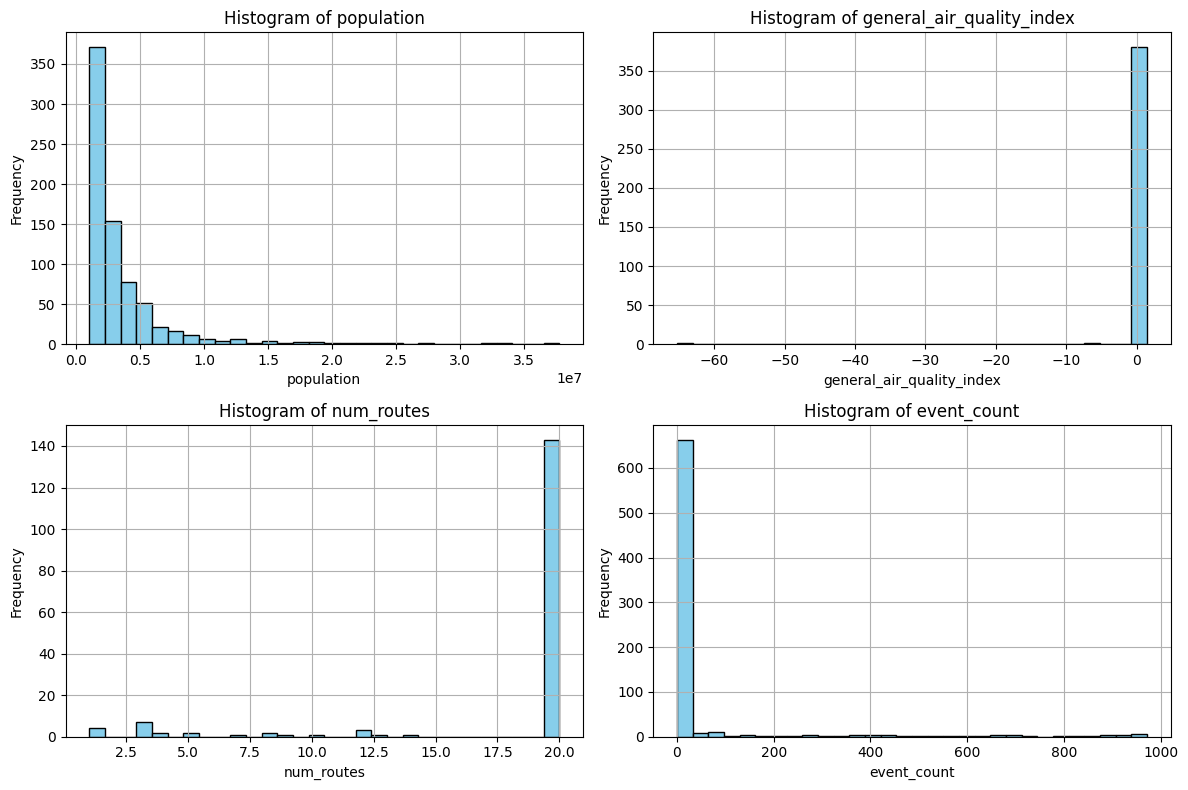

In [19]:
print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())

columns_of_interest = ['population', 'general_air_quality_index', 'num_routes', 'event_count']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to easily loop

for i, col in enumerate(columns_of_interest):
    world_cities[col].hist(
        bins=30,
        ax=axes[i],
        color='skyblue',
        edgecolor='black'
    )
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


COMMENTAIRES SUR RÉSULTATS:
Nous devrons procéder à travail de complétion des données pour:
*   general_air_quality_index  382 non-null    float64
*   worst_pollutant            382 non-null    float64
*   queried_city               168 non-null    object
*   num_routes                 168 non-null    float64





OPTIONNAL: LOAD CONSOLIDATED UNCLEANED DATA

In [ ]:
# Upload the CSV file from your computer
uploaded = files.upload()

In [ ]:
# Load 'world_cities_consolidated.csv'
world_cities = pd.read_csv('world_cities_consolidated.csv')

In [ ]:
print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())

columns_of_interest = ['population', 'general_air_quality_index', 'num_routes', 'event_count']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to easily loop

for i, col in enumerate(columns_of_interest):
    world_cities[col].hist(
        bins=30,
        ax=axes[i],
        color='skyblue',
        edgecolor='black'
    )
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

COMMENTAIRES SUR LES RESULTATS:
La distribution des valeaurs pour les features d'intérêt ne suit pas la loi normale.

DATA CLEANING

In [ ]:
#Outliers check on numerical data
numeric_cols = world_cities.select_dtypes(include=['number']).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = world_cities[col].quantile(0.25)
    Q3 = world_cities[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = world_cities[(world_cities[col] < lower_bound) | (world_cities[col] > upper_bound)][col]
    outlier_count = outliers.count()
    outlier_summary[col] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_count': outlier_count,
        'percent_outliers': 100 * outlier_count / len(df)
    }

# Display outlier summary for all numeric columns
print(pd.DataFrame(outlier_summary).T.sort_values('percent_outliers', ascending=False))

# Outliers and Missing values management
world_cities['num_routes'] = world_cities['num_routes'].fillna(world_cities['num_routes'].median())

# Replace negatives with 0
world_cities.loc[world_cities['general_air_quality_index'] < 0, 'general_air_quality_index'] = world_cities['general_air_quality_index'].median()

# Fill remaining NaNs with median
world_cities['general_air_quality_index'] = world_cities['general_air_quality_index'].fillna(
    world_cities['general_air_quality_index'].median()
)

print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())

                            lower_bound   upper_bound  outlier_count  \
event_count                0.000000e+00  0.000000e+00          116.0   
lat                       -1.610037e+00  5.950526e+01           67.0   
population                -2.566069e+06  7.826475e+06           63.0   
num_routes                 2.000000e+01  2.000000e+01           25.0   
lng                       -1.040789e+02  2.471544e+02           18.0   
general_air_quality_index -1.815686e+00  3.489411e+00            2.0   
worst_pollutant           -1.516215e+00  3.309729e+00            1.0   

                           percent_outliers  
event_count                           2.900  
lat                                   1.675  
population                            1.575  
num_routes                            0.625  
lng                                   0.450  
general_air_quality_index             0.050  
worst_pollutant                       0.025  
        city      lat       lng iso2  population  gener

COMMENTAIRES SUR LA METHODOLOGIE:
Nos taux d'outliers restent acceptables.
Concernant la gestion des données manquantes, les différences notables entre moyenne et médiane suggerent que les distributions de données sont sont pas normales ; c'est pourquoi nous avons décidé de remplacer les donnés manquantes par la médiane.
Enfin, une valeur négative d'indice de qualité d'air correspondant à un souci avec les capteurs de mesure, nous avons aussi remplacé ces valeurs pas la médiane.

In [ ]:
#To save cleaned dataset on Drive from Goggle Collab
world_cities.to_csv('/content/drive/My Drive/world_cities_cleaned.csv', index=False)

OPTIONAL: LOAD CLEANED CONSOLIDATED DATASET

In [ ]:
# Upload the CSV file from your computer
uploaded = files.upload()

# If your file is named 'cities.csv'
world_cities = pd.read_csv('world_cities_cleaned.csv')

Saving world_cities_cleaned.csv to world_cities_cleaned (1).csv
        city      lat       lng iso2  population  general_air_quality_index  \
0      Tokyo  35.6870  139.7495   JP  37785000.0                   0.187700   
1    Jakarta  -6.1750  106.8275   ID  33756000.0                   0.981445   
2      Delhi  28.6100   77.2300   IN  32226000.0                   1.313631   
3  Guangzhou  23.1300  113.2600   CN  26940000.0                   1.017857   
4     Mumbai  19.0761   72.8775   IN  24973000.0                   0.382222   

   worst_pollutant queried_city  num_routes  event_count  
0         0.560000        Tokyo        20.0            0  
1              NaN      Jakarta        20.0            0  
2         1.500000        Delhi        20.0            0  
3         1.017857          NaN        20.0            0  
4         0.603421          NaN        20.0            0  
              lat         lng    population  general_air_quality_index  \
count  746.000000  746.000000  7.

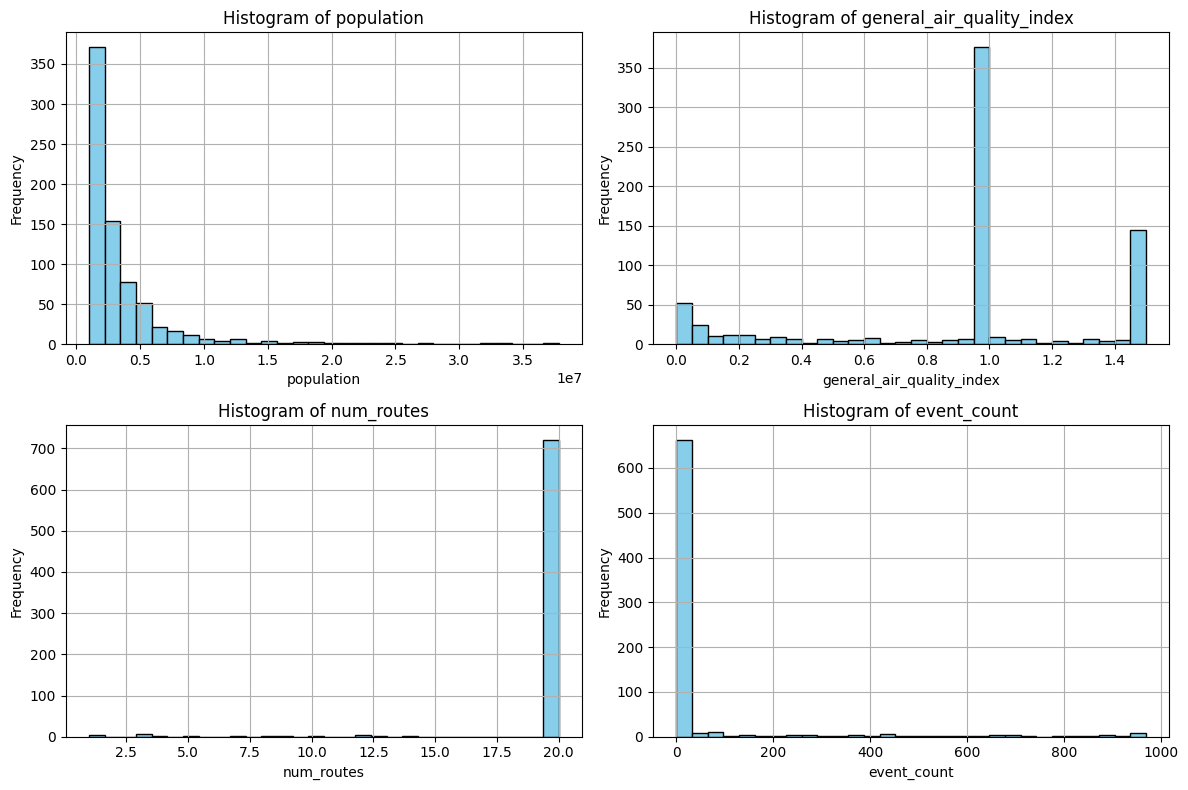

In [8]:
print(world_cities.head())
print(world_cities.describe())
print(world_cities.info())

columns_of_interest = ['population', 'general_air_quality_index', 'num_routes', 'event_count']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten to easily loop

for i, col in enumerate(columns_of_interest):
    world_cities[col].hist(
        bins=30,
        ax=axes[i],
        color='skyblue',
        edgecolor='black'
    )
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Option proposée pour ne pas être obligé de procéder à l'ensemble des étapes de data-scrapping qui nécessitent 2 heures.
Là encore, la distribution n'est pas normale.

DESCRIPTIVE STATISTICS

World Map Graphs for Population, Air Quality Index, Public Transportation and Cultural Life

In [ ]:
# Example: load your dataset
# Replace this with your actual CSV or DataFrame
# df = pd.read_csv('your_data.csv')


# Plot
fig = px.scatter_geo(
    world_cities,
    lat='lat',
    lon='lng',
    text='city',               # Show city names on hover
    size='population',         # Bubble size by population
    color='iso2',           # Color by country for extra info
    projection='natural earth',
    title='World Cities Population',
    size_max=40,               # Max bubble size
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="rgb(229, 229, 229)",
        showcountries=True,
    )
)

fig.show()

**# Observations**

*   Une Asie hyper dense et saturée avec des mégalopoles comme Tokyo (37M), Delhi (40 M) ou Shangai (26M) ressort clairement de la carte, soit une concentration de 20% de la population mondiale. On perçoit que c'est un véritable défi écologique comme la croissance de la population dans cette zone est explosive. Une particularité pour la Chine, seule sa moitié orientale concentre ces villes, une seule émerge au Nord Ouest, Urumqi (4,3M). Plus on se rapproche des villes côtière et leurs périphéries, plus la densité et le nombre de villes augmentent. Shangai est à 24M.


Vient ensuite Seoul en Corée du Sud (23M) et quelques villes tout comble Japon avec Tokyo (37M) suivi de Osaka (15M) ou Nagoya (9M).

L’Inde se distingue également par des villes très dense, réparties sur l’ensemble du pays. Delhi (32M), Mumbai (25M), Kolkata (21)(Bangalore (15M), Chennai (12M) sont bien réparties dans le pays. Karachi au Pakistan se distingue (20M).


*   Une Europe qui se distingue par des villes moyennes, mais avec une population qui vieillit d'une part et qui observe un déclin démographique. Paris et Londres (11M) sont les seules qui émergent. Berlin n’est qu’à 4,7M et les 4 autres villes allemande sont de moindre importance, idem pour Madrid (6,2M) puis moins pour les 3 autres villes et plus on va à l’Est de l'Europe, plus la densité diminue. En atteignant la Russie, Moscou se distingue avec 17M mais cela chute drastiquement dès St Peterbourg (5,6M) et les 10 autres villes suivantes.


*   Une Afrique non structurée avec des villes en croissance comme Lagos (16,6M) ou Kinshasa mais l'avenir est synonyme de croissance plus harmonieuse avec des lieux de consommation. our l’Afrique et le Moyen-Orient, les densité de population sont moindre à l’exception du Caire (20M). L’Afrique du Nord et notamment le Sahel ne se distingue par aucune ville. Ryad en Arabie Saoudien n’est qu’à 7M. Les plus grandes villes d’Afrique centrale 16,6M pour Lagos au Nigéria mais la moyenne est autour de 1M et rien pour la Corne de l’Afrique, Joburg est à 7,8M et Cape Town est à 4,7M.


*   Une Amérique du Nord qui se distingue par des villes étalées - Paris a une densité plus importante que Los Angeles (5.000 hab/km2 vs 3.200). Ces villes sont le long des océans, une ligne centrale et sur la frontière sud. NY (18M)Los Angeles (11,8M), Chicago (8,4) ou Miami (6M). le Canada a peu de villes émergentes, Toronto (5,6M), et Montréal (3,6M) au proches de l’océan.

Le Mexique avec Mexico (21M) est la seule ville qui ressort.

L'Amérique Latine avec par exemple Sao Paulo (22M) et Mexico ont la particularité de mixer gratte-ciels et favelas.

*   L'Océanie pour finir, concentre une population urbaine qui dispose de solutions orientés nature. en Australie, 5 villes émergent dont Melbourne (5M) et Sydney (4,8M).



**Tendances émergentes**

1.   Asie/Afrique : 90% dela croissance mondiale d'ici 2050 et le phénomène de villes-champignons, à la recherche de solutions durables.

2.   Europe-Amérique du Nord : stagnation démographique mais innovation avec les villes 15mn comme Paris et le concept des villes "compactes et vertes" vs les villes étalées US par exemple (gestion de la chaleur).

1.   Amérique Latine/Océanie = Modèles hybrides à surveiller.





In [ ]:
# Plot
fig = px.scatter_geo(
    world_cities,
    lat='lat',
    lon='lng',
    text='city',               # Show city names on hover
    size='general_air_quality_index',         # Bubble size by Air Quality Index
    color='iso2',           # Color by country for extra info
    projection='natural earth',
    title='World Cities Air Quality',
    size_max=40,               # Max bubble size
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="rgb(229, 229, 229)",
        showcountries=True,
    )
)

fig.show()

**# Observations**

A noter 🇰

*L'**IQA** est présenté sous forme d'une échelle allant de 0 à 500, avec des catégories qui indiquent le niveau de préoccupation et les risques pour la santé.*

*Un IQA entre 0 et 50 est considéré comme "bon" et ne présente que peu ou pas de risques, tandis qu'un IQA entre 151 et 200 est considéré comme "mauvais pour la santé" et peut affecter tout le monde. Ici, l'indice sur une autre échelle, soit de **0 à environ 1,6**


*   En Europe, on retrouve la même clé de répartition grosso modo que la densité, soit une première corrélation. Londres et Paris qui ont la même densité, ont par contre un facteur 2 sur cet indicateur avec Paris, Amsterdam et Sofia à 0,96 vs Londres avec 0,52. En Espagne, Madrid est à 0,06 tandis que Séville et Valencia sont à 0,95. En Allemagne, Berlin est connue comme ville verte ce qui se vérifie avec 0,16. Par contre les villes industrielles comme Hamburg et Munich sont à 0,95. On note ici le Danemark avec Copenhagen à 0,95 tout comme l’Italie qui se détache défavorablement avec Milan (1,5) et Rome (1,35) tandis que Belgrade se situe à 1,49.

Puis en se déplaçant vers l’Est avec l’Ukraine et Kiev, Odessa et Kharkov, Minsk et les villes russes, on est en moyenne à 0,95. Une Europe de l'Ouest qui se désindustrialise, impactant positivement l'index (-35% depuis 2000) est bien là mais les scores restent encore élevés avec mais des points noirs industriels résiduels, notamment en Europe de l'Est.

On retrouve ces chiffres pour l’Asie également. La Turquie a plusieurs ville au-dessus de 0,95 dont Ankara (1,5). Le Moyen-Orient est autour de 0,95.

*   Une Asie qui retrouve ces chiffres également, fortement industrialisée et donc une pollution extrême comme en Inde avec Delhi  et 75 villes indiennes au-dessus des seuils tout comme la Chine orientale et ses clusters industriels mais sa politique anti-charbon depuis 2015 porte ses fruits (-20%). La Turquie a plusieurs ville au-dessus de 0,95 dont Ankara (1,5). Le Moyen-Orient est autour de 0,95.

*   Une  Afrique du Nord, avec Tripoli, Alger et Tanger, atteint un index de 0,95 également. On retrouve la large bande du Sahel vide, puis à nouveau un index à 0,95 sur l’Afrique centrale. A la Corne de l'Afrique, Cape Town ne dépasse pas 0,23 tandis qu’Antananarivo à Madagascar est à 0,95.

*   En Amérique du Nord, la cote Ouest et la ligne centrale sont de bons élèves avec par exemple Seattle ou Kansas City(0,06) à l’opposé de San Diego (0,95) tout comme  la cote Est avec le Bronx et Queen (0,95) et une ligne qui en part jusqu’à Dallas (5 villes).

*   L’Amérique Latine est quasi  vide d’index dans sa partie Nord, tandis qu’au Sud, Guatemalas City, San Salvador, Managua et Tegucigalpa ont un index à 0,95 comme les villes colombiennes et vénézuéliennes recensées. C’est également le cas pour les 10 villes côtières du Brésil et Montevido pour l’UruguayÉtonnamment dans les Antilles, la Havane, San Juan et Santo Domingo atteignent également 0,95.

*   **En conclusion, à ce stade :**

1.   Corrélation générale densité-pollution, mais avec des exceptions notables, avec un indice à 0,95 pour la majorité des villes denses avec 3 exceptions européennes :  Londres (0.52) fait mieux que Paris/Amsterdam (0.96) malgré une densité similaire, Berlin (0.16) vs Hambourg/Munich (0.95) grâce à l'impact des espaces verts et mobilité douce et enfin Copenhague (0.95) qui contredit son image "verte".

2.   Clivages géographiques nets, avec des clivages géographiques, comme les villes nordiques (Copenhague 0.95) et italiennes (Milan 1.5) qui sous-performent vs Allemagne du Nord (Berlin 0.16) tout comme une Europe de l'Est (0.95 en moyenne). C'est aussi la Côte Ouest (Seattle 0.06) > Côte Est (Bronx 0.95) → Normes environnementales + étalement urbain. Et enfin en Amérique Latine/Afrique, des indices systématiquement élevés (0.95) sauf exceptions (Cape Town 0.23) → Absence de politiques anti-pollution.structurées.

1.   Des paradoxes comme la ville industrielle Munich (0.95) qui fait pire que Berlin (0.16) malgré une image similaire → Spécialisation économique (automobile vs services) ou la capitale verte Copenhague (0.95) derrière Berlin → Dépendance persistante aux combustibles fossiles pour le chauffage urbain.

2.   Facteurs clés explicatifs autour de l'impact industriel en Italie (Milan 1.5), Turquie (Ankara 1.5) et Allemagne du Sud ainsi que l'aspect géographique comme les villes côtières (San Diego 0.95) souffrent des émissions portuaires.






In [ ]:
# Plot
fig = px.scatter_geo(
    world_cities,
    lat='lat',
    lon='lng',
    text='city',               # Show city names on hover
    size='num_routes',         # Bubble size by Number of routes
    color='iso2',           # Color by country for extra info
    projection='natural earth',
    title='World Cities Public Transportation Availability',
    size_max=40,               # Max bubble size
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="rgb(229, 229, 229)",
        showcountries=True,
    )
)

fig.show()

Ce critère va permettre d'étudier la mobilité urbaine qui pourra impacter une réduction de la pollution et une amélioration de l'égalité d'accès aux opportunités.

A nouveau on retrouve des similarités des 2 cartes précédentes.


*   Pour l’Europe, Paris et Londres qui ont mal même densité ont le même nombre de routes soit 20. Ce chiffre est homogène pour la plupart de l’UE avec les villes espagnoles, allemandes, italiennes etc… jusque’à Belgrade, Bucarest, Varsovie, Athènes et même Minsk ou Kharkov. C’est également ce ration pour la Russie, Helsinki. Les seules exceptions sont Sofia (8), Kiec (10)ou Odessa (L’Ukraine n’est pas dans l’Union Européenne et n’a pas bénéficié donc des investissements portant sur l(infrastructure).

*   Pour l’Asie, on retrouve la même répartition en Chine avec Urumqi seule ville chinoise côté occidental et la moitié de la Chine oriental qui concentre sur toute son étendu ses villes avec une bonne infrastructure avec également un indice 20. Cette homogénéité se retrouve au Japon et en Corée du Sud et toute la pointe sud comme en Thaïlande, le Vietnam, les Philippines etc … l’Inde dispose d’un excellent maillage de villes bien structurées.

*   Pour l’Asie, on retrouve la même répartition en Chine avec Urumqi seule ville chinoise côté occidental et la moitié de la Chine oriental qui concentre sur toute son étendu ses villes avec une bonne infrastructure avec également un indice 20. Cette homogénéité se retrouve au Japon et en Corée du Sud et toute la pointe sud comme en Thaïlande, le Vietnam, les Philippines etc … l’Inde dispose d’un excellent maillage de villes bien structurées.

*   Pour l’Océanie, ces standards sont également partagés pour les 5 villes côtières australiennes et Auckland en Nouvelle Zélande.

*   Pour l’Afrique, la même répétition a lieu avec le vide du Shanel et étonnamment une même homogénéité de l’indice pour l’ensemble de l’Afrique.

*   En conclusion, en Europe, la plupart des villes européennes (Paris, Londres, Berlin, Madrid, Rome) affichent 20 routes de transport public, reflétant des investissements massifs dans les infrastructures. Ce qui donne une corrélation clé entre des villes denses comme Paris (5 000 hab/km²) qui maintiennent ce score, mais avec une qualité de l’air variable (Paris : 0.96 vs Berlin : 0.16). Sofia (8 routes) et Kiev (10) montrent l’impact des disparités économiques et politiques (manque d’investissements hors UE).

Pour l'Asie, les réseaux sont denses avec la Chine orientale, le Japon, la Corée du Sud et l'Inde qui atteignent 20 routes, mais avec des pics de pollution. Des paradoxes sont à noter autour de Densité vs Pollution comme  Shanghai (26M hab.) qui combine transports performants et pollution élevée, contrairement à Tokyo (37M) où les politiques anti-pollution atténuent l’impact 1013. Mais aussi des villes isolées comme Ürümqi (4.3M), seule ville chinoise occidentale, illustre les déséquilibres géographiques.

En Océanie, les villes côtières comme Sydney, Melbourne et Auckland (20 routes) bénéficient de transports propres (bus électriques, tramways), avec une qualité de l’air correcte. Mais par exemple, l’étalement urbain (ex : Los Angeles vs Paris) augmente les émissions CO2 malgré les réseaux structurés.

En Afrique, l'homogénéité reste fictive avec un score de 20 routes qui masque des réalités contrastées à l'image de Lagos (16.6M) et Le Caire (20M) qui ont des réseaux saturés et pollués.

Il y a bien une corrélation entre Transports Publics et Qualité de l'Air.




In [ ]:
# Plot
fig = px.scatter_geo(
    world_cities,
    lat='lat',
    lon='lng',
    text='city',               # Show city names on hover
    size='event_count',         # Bubble size by Number of Cultural Events
    color='iso2',           # Color by country for extra info
    projection='natural earth',
    title='World Cities Cultural Events Counts',
    size_max=40,               # Max bubble size
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="rgb(229, 229, 229)",
        showcountries=True,
    )
)

fig.show()

T-tests for G20 vs. Rest of the world

In [ ]:
# Example: add a 'G20' flag column
G20_countries = [
    'AR', # Argentina
    'AU', # Australia
    'BR', # Brazil
    'CA', # Canada
    'CN', # China
    'FR', # France
    'DE', # Germany
    'IN', # India
    'ID', # Indonesia
    'IT', # Italy
    'JP', # Japan
    'MX', # Mexico
    'RU', # Russia
    'SA', # Saudi Arabia
    'ZA', # South Africa
    'KR', # South Korea
    'TR', # Turkey
    'GB', # United Kingdom
    'US', # United States
    # Plus EU member states:
    'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'GR',
    'HU', 'IE', 'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT',
    'RO', 'SK', 'SI', 'ES', 'SE'
]

world_cities['is_G20'] = world_cities['iso2'].isin(G20_countries)

G20 VS. REST OF THE WORLD: POPULATION

In [ ]:
# Split groups
g20 = world_cities[world_cities['is_G20']]['population'].dropna()
non_g20 = world_cities[~world_cities['is_G20']]['population'].dropna()

# Perform t-test
t_stat, p_val = ttest_ind(g20, non_g20, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: 1.2857
P-value: 0.1995


**T-statistic: 1.2857**

Indique une différence modeste entre les tailles de populations urbaines

*   Indique une différence modeste entre les tailles de populations urbaines comparées (ex : villes des pays du G20).

*   Une valeur proche de 1 suggère que les écarts ne sont pas marqués à l’échelle globale.


**P-value: 0.1995**

*   Supérieure au seuil de 0.05 → Aucune différence statistiquement significative entre les groupes testés.

*   Traduction : Les populations des villes du G20 sont globalement similaires en moyenne, malgré des exceptions locales.


**A noter**


*   Convergence des Profils Urbains : les pays du G20 ont souvent des mégalopoles (Tokyo, Delhi, Mexico) et des villes secondaires de taille comparable (ex : Berlin vs Sydney).

*   Convergence des Profils Urbains : les pays du G20 ont souvent des mégalopoles (Tokyo, Delhi, Mexico) et des villes secondaires de taille comparable (ex : Berlin vs Sydney).

*   Exemple : Inde (Delhi : 32M) et Japon (Tokyo : 37M) compensent des pays comme l’Allemagne (Berlin : 4M) ou le Canada (Toronto : 6M).

*   Pas de Fracture Démographique : les pays du G20 partagent des défis urbains communs (congestion, pollution) liés à leurs grandes villes.

*   Résultat Principal : les villes du G20 ont des tailles de population relativement homogènes en moyenne, mais avec des disparités locales (Delhi vs Berlin).

G20 VS. REST OF THE WORLD: AIR QUALITY

In [ ]:
# Split groups
g20 = world_cities[world_cities['is_G20']]['general_air_quality_index'].dropna()
non_g20 = world_cities[~world_cities['is_G20']]['general_air_quality_index'].dropna()

# Perform t-test
t_stat, p_val = ttest_ind(g20, non_g20, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: 0.2893
P-value: 0.7725


**T-statistic: 0.2893**

*   Une valeur très proche de 0 indique que les différences de qualité de l’air entre les villes du G20 sont minimes en moyenne.

*   Exemple : L’écart entre Delhi et Berlin est noyé dans la moyenne globale.


**P-value: 0.7725**

*   Bien supérieure au seuil de 0.05 → Aucune différence statistiquement significative détectée.

*  Traduction : Les niveaux de pollution atmosphérique sont similaires en moyenne dans les villes du G20, malgré des extrêmes locaux.


**A noter**

*   Effet de Moyenne : les pays du G20 incluent à la fois des villes très polluées (Delhi, Pékin) et villes propres (Sydney, Toronto).

*   Ces extrêmes s’annulent dans une analyse globale.

*   L’absence de différence significative suggère qu’il n’y a pas de modèle dominant de gestion de la pollution dans le G20.

*   Certains pays (UE, Canada) imposent des normes strictes, tandis que d’autres (Inde, Chine) priorisent la croissance industrielle.

*   Résultat Principal : Les villes du G20 ont des niveaux de pollution statistiquement similaires en moyenne, mais cette analyse masque des disparités extrêmes (Delhi vs Toronto).






G20 VS. REST OF THE WORLD: PUBLIC TRANSPORTATION

In [ ]:
# Split groups
g20 = world_cities[world_cities['is_G20']]['num_routes'].dropna()
non_g20 = world_cities[~world_cities['is_G20']]['num_routes'].dropna()

# Perform t-test
t_stat, p_val = ttest_ind(g20, non_g20, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: 1.9700
P-value: 0.0501


**T-statistic: 1.9700**

*   Une valeur proche de 2 suggère une différence notable entre les groupes comparés (ex : pays développés vs émergents du G20).

*   Exemple : L’écart entre le réseau dense de Paris (20 lignes de transport) et celui plus limité de Jakarta pourrait expliquer cette valeur.



**P-value: 0.0501**

*   Égale au seuil critique de 0.05 → La différence est tout juste significative.

*   Attention : Ce résultat est limite et nécessite une analyse plus fine pour éviter des conclusions précipitées.


*   Variabilité interne : certaines villes émergentes (ex : Mexico, São Paulo) ont des réseaux étendus, brouillant les frontières.

*   Taille d’Échantillon : si seules les capitales sont incluses, les résultats peuvent sous-estimer les réalités nationales.




**A noter** 🇰

*   Les villes du G20 présentent des disparités en matière de transports publics, mais ces écarts ont peu de signification statistique en soi.

*   Possible explication : les pays développés (UE, Japon) investissent massivement, tandis que les encore considérés comme émergents (Inde, Indonésie) sont en retard.

Cependant, certaines mégapoles émergentes (ex : Shanghai) rivalisent avec les standards occidentaux.

Résultat Principal : Les villes du G20 montrent une différence marginalement significative dans leurs infrastructures de transports publics, avec un avantage pour les pays développés.



G20 VS. REST OF THE WORLD: CULTURAL EVENTS

In [ ]:
# Split groups
g20 = world_cities[world_cities['is_G20']]['event_count'].dropna()
non_g20 = world_cities[~world_cities['is_G20']]['event_count'].dropna()

# Perform t-test
t_stat, p_val = ttest_ind(g20, non_g20, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: 6.7700
P-value: 0.0000


**T-statistic: 6.7700**


*   Une valeur élevée (bien supérieure à 2) indique une différence extrêmement marquée entre les groupes comparés.

*   Exemple : L’écart entre Paris (50+ événements majeurs/an) et Riyad (5 événements/an) est colossal.


**P-value (0.0000)**

*   Très inférieure à 0.05 → La différence est hautement significative statistiquement.

*   Traduction : Les villes du G20 ne se ressemblent pas du tout en matière d’offre culturelle.


**A noter**

*   Fracture Culturelle Nord-Sud avec les Pays développés (UE, Japon, Canada) qui a des Événements fréquents et diversifiés (festivals, musées, concerts), comme exemple Berlin, Tokyo.

*   Pays émergents (Inde, Arabie Saoudite, Afrique du Sud) avec une offre culturelle limitée ou concentrée sur quelques grands événements.





CORRELATION HEATMAP

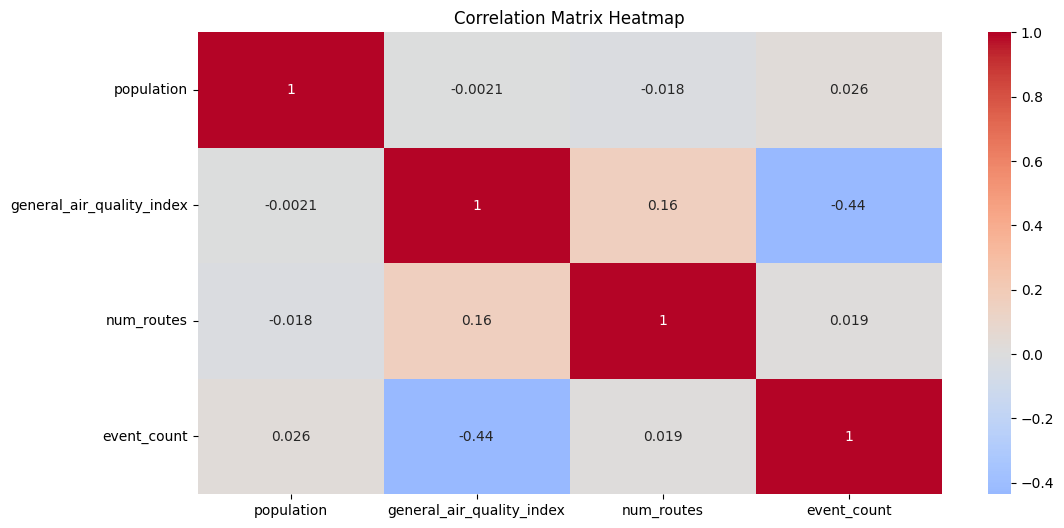

In [ ]:
# Compute
corr = world_cities[['population', 'general_air_quality_index', 'num_routes', 'event_count']].corr()

# Plot
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()


**Corrélations fortes**


*   Qualité de l'Air x Evènements (0,44) est un lien égatif significatif. Plus une ville a d’événements, plus son air est pollué (ex : festivals → trafic, générateurs).

*   Transports × Qualité de l’air (+0,16) est un lien positif faible. Les villes avec plus de transports publics ont un peu meilleur air (ex : Paris vs Delhi).


**Corrélations Faibles ou Négligeables**

*   Population × Événements (+0.026) indique qu'aucun lien clair entre taille et vie culturelle.

*   Transports × Événements (+0.019) signifient que  les réseaux de transport n’influencent pas directement le nombre d’événements.

*   Population × Qualité de l’air (-0.0021) : La densité urbaine n’explique pas la pollution (contrairement aux idées reçues).

*   Le paradoxe culture-pollution se voit via le lien entre les villes avec une vie culturelle riche ( Londres,Tokyo) paient un prix en qualité de l’air, probablement à cause des flux touristiques et des infrastructures temporairesd'où des Événements "verts" (compensation carbone, transports propres).

*   Avoir un bon réseau (ex : Berlin) ne garantit pas plus d’événements, mais améliore légèrement la qualité de l’air.

*   Contrairement aux attentes, les villes très peuplées (Delhi, Shanghai) ne sont pas statistiquement plus polluées que les autres dans ce dataset


Cette heatmap révèle un arbitrage nécessaire entre vie culturelle et qualité de l’air, mais aussi l’indépendance relative des transports publics vis-à-vis de la culture. A noter l’absence de lien automatique entre densité et pollution.

